#### first lab  https://github.com/itmo-ml-lab-ML-course/parser-zji25

#### fixing input table

In [227]:
import pandas as pd
import warnings
from scipy.linalg import LinAlgWarning
from pandas.errors import SettingWithCopyWarning

inp = pd.read_csv('cian.csv', parse_dates=['Дата'], date_format='%d %m %H:%M', index_col=0)
new_column_names = {
    'ID': 'id', 'Дата': 'date', 'Цена': 'price', 'Район': 'district', 'Залог': 'deposit',
    'Комиссия': 'fee', 'Предоплата': 'adv_payment_months', 'Срок аренды': 'period',
    'Общая площадь': 'area', 'Год постройки': 'year'
}
inp = inp.rename(columns=new_column_names)
inp.dropna(subset=['date'], inplace=True)
inp.date = inp.date.apply(lambda w: w.replace(year=2023))

replacement_dict = {'1 месяц': 1, '2 месяца': 2, '6 месяцев': 6, '3 месяца': 3}
inp.adv_payment_months.replace(replacement_dict, inplace=True)
inp.adv_payment_months.fillna(0, inplace=True)
inp.adv_payment_months = inp.adv_payment_months.astype(int)

## filling year's nans with average
inp.year.fillna(inp.year.mean(), inplace=True)
inp.year = inp.year.astype(int)

inp.deposit.fillna(0, inplace=True)

rows_with_nan = inp[inp.isna().any(axis=1)]
assert len(rows_with_nan) == 0, 'still some rows with nan'

inp.head()

,id,date,price,district,deposit,fee,adv_payment_months,period,area,year
0,292731391,2023-09-30 23:15:00,38000.0,Выборгский,38000.0,0.66,1,несколько месяцев,28.0,2019
1,283791063,2023-09-30 09:07:00,36990.0,Выборгский,30000.0,0.00,1,от года,28.0,1978
2,244958937,2023-09-30 08:19:00,31990.0,Выборгский,30000.0,0.00,1,несколько месяцев,28.0,1978
3,293084840,2023-08-29 22:19:00,90000.0,Центральный,90000.0,1.00,1,от года,68.0,2014
4,286572977,2023-10-01 11:12:00,35000.0,Центральный,25000.0,0.00,1,от года,19.0,1873


#### more converting

In [228]:
df = inp.copy()
df.drop(columns=['id'], inplace=True)
df.date = df.date.astype(int)
df.period.replace({'несколько месяцев': 0, 'от года': 1}, inplace=True)

def normalize(d):
    return (d-d.min())/(d.max()-d.min())
    
df.area = normalize(df.area)
df.date = normalize(df.date)
df.deposit = normalize(df.deposit)
df.year = normalize(df.year)
df.head()

,date,price,district,deposit,fee,adv_payment_months,period,area,year
0,0.989673,38000.0,Выборгский,0.033778,0.66,1,0,0.062016,0.986441
1,0.979515,36990.0,Выборгский,0.026667,0.00,1,1,0.062016,0.847458
2,0.978940,31990.0,Выборгский,0.026667,0.00,1,0,0.062016,0.847458
3,0.436974,90000.0,Центральный,0.080000,1.00,1,1,0.217054,0.969492
4,0.998263,35000.0,Центральный,0.022222,0.00,1,1,0.027132,0.491525


#### модель ближайшего соседа

In [229]:
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score

def model_with_one_hyperparameter(
        construct_model, get_best_parameter, parameter_range, parameter_name, title,
        _x_train, _x_valid, _x_test, _y_train, _y_valid, _y_test,
        is_classification=True, draw_tree=False):
    best_model, min_error, errors = None, float('inf'), []
    for p in parameter_range:
        model = construct_model(p)
        model.fit(_x_train, _y_train)
        y_valid_predictions = model.predict(_x_valid)
        if is_classification:
            error = 1-accuracy_score(y_valid_predictions, _y_valid)
        else:
            error = mean_squared_error(y_valid_predictions, _y_valid)
        errors.append(error)
        if error < min_error:
            best_model, min_error = model, error
    y_test_predictions = best_model.predict(_x_test)
    print('best model\n  {}: {}\n  valid error: {}\n  test error:  {}'
          .format(parameter_name, get_best_parameter(best_model),
                  min_error, mean_squared_error(y_test_predictions, _y_test)))
    if draw_tree:
        plt.figure(figsize=(20, 15))  
        plot_tree(best_model, filled=True, fontsize=8)
        plt.show()
    figure, axis = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])
    plt.suptitle(title)
    axis[0].set_title('looking for the best hyperparameter')
    axis[0].set_xlabel(parameter_name)
    axis[0].set_ylabel('error')
    axis[0].plot(parameter_range, errors)
    line = np.linspace(min(y_test_predictions), max(y_test_predictions), 100)
    axis[1].set_title('using best parameters on test data')
    if is_classification:
        disp = DecisionBoundaryDisplay.from_estimator(best_model, _x_test,
                                                      response_method='predict', ax=axis[1])
        disp.ax_.scatter(_x_test.price, _x_test.year, c=_y_test, edgecolor="k")
    else:
        axis[1].plot(line, line, color='#f29a4e', label='x=y')
        axis[1].legend()
        axis[1].scatter(_y_test, y_test_predictions, s=8)
        axis[1].set_xlabel('real y_test')
        axis[1].set_ylabel('predicted y_test')
    plt.tight_layout()
    plt.show()

#### splitting data

In [230]:
from sklearn.model_selection import train_test_split

def train_valid_test_split(X, Y, valid_size, test_size):
    _x_train, _x_test, _y_train, _y_test = train_test_split(X, Y, test_size=test_size, random_state=1)
    _x_train, _x_valid, _y_train, _y_valid = train_test_split(
        _x_train, _y_train, test_size=valid_size/(1-test_size), random_state=1)
    return _x_train, _x_valid, _x_test, _y_train, _y_valid, _y_test

df_p = pd.get_dummies(df, columns=['district'])
y = df_p[['price']]
x = df_p.drop(columns=['price'])
# 60% train 20% valid 20% test
x_train_price, x_valid_price, x_test_price, y_train_price, y_valid_price, y_test_price \
    = train_valid_test_split(x, y, 0.2, 0.2)
print('train: {}, valid: {}, test: {}'.format(len(x_train_price), len(x_valid_price), len(x_test_price)))

train: 895, valid: 299, test: 299


best model
  number of neighbors: 6
  valid error: 603141424.0767373
  test error:  1009352280.1492009


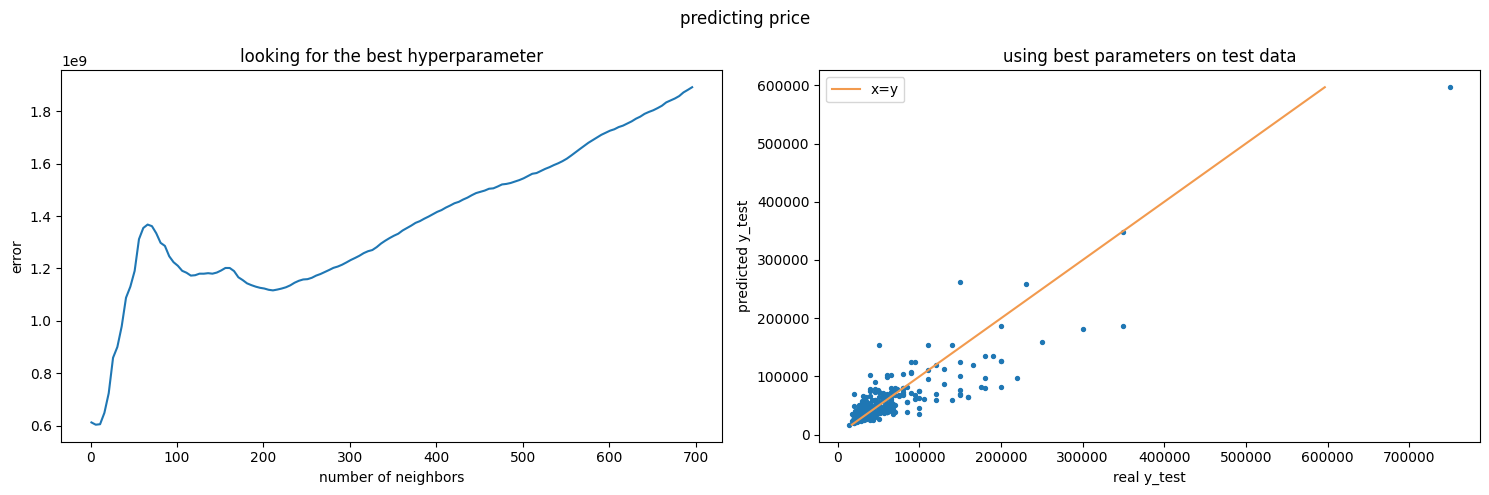

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

n_neighbors_range = range(1, 700, 5)
model_with_one_hyperparameter(
    lambda p: KNeighborsRegressor(n_neighbors=p), lambda model: model.n_neighbors,
    n_neighbors_range, 'number of neighbors', 'predicting price', 
    x_train_price, x_valid_price, x_test_price, y_train_price, y_valid_price, y_test_price, 
    is_classification=False)

In [232]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

districts_amount_used = 3
common_values = df.district.value_counts().nlargest(districts_amount_used).index.tolist()
ds = df[df.district.isin(common_values)]
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
ds.price = normalize(ds.price)
ds.head()

,date,price,district,deposit,fee,adv_payment_months,period,area,year
3,0.436974,0.221557,Центральный,0.080000,1.0,1,1,0.217054,0.969492
4,0.998263,0.056886,Центральный,0.022222,0.0,1,1,0.027132,0.491525
5,0.415435,0.113772,Центральный,0.040000,0.0,1,0,0.054264,0.989831
6,0.415543,0.089820,Центральный,0.040000,0.0,1,1,0.054264,0.989831
7,0.997089,0.056886,Центральный,0.031022,0.0,1,0,0.069767,0.400000


best model
  number of neighbors: 17
  valid error: 0.24615384615384617
  test error:  0.5461538461538461


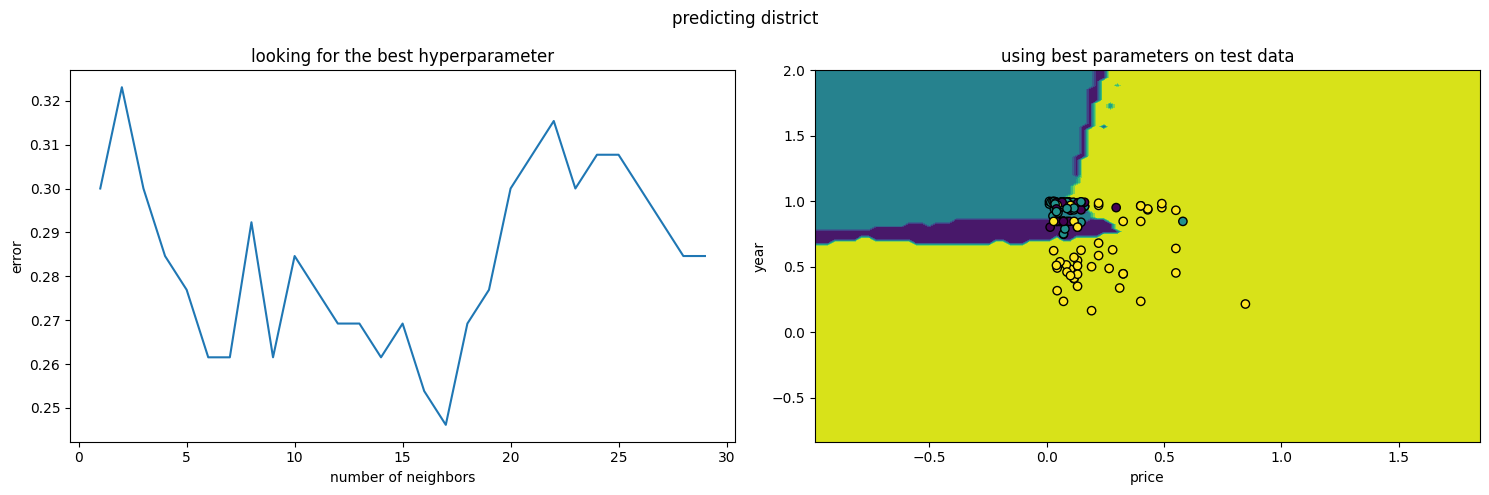

In [233]:
y_ds = ds[['district']]
x_ds = ds[['price', 'year']]
y_ds = LabelEncoder().fit_transform(y_ds.district)
x_train_ds, x_valid_ds, x_test_ds, y_train_ds, y_valid_ds, y_test_ds \
    = train_valid_test_split(x_ds, y_ds, 0.2, 0.2)

model_with_one_hyperparameter(
    lambda p: KNeighborsClassifier(n_neighbors=p), lambda model: model.n_neighbors,
    range(1, 30), 'number of neighbors', 'predicting district',
    x_train_ds, x_valid_ds, x_test_ds, y_train_ds, y_valid_ds, y_test_ds)

#### линейная модель
**RIDGE** - linear least squares with l2 regularization

minimizes the objective function: $||y-Xw||^2_2 + \alpha \cdot ||w||^2_2$

best model
  alpha: 0.01
  valid error: 90362468.85752277
  test error:  135465043.79286358


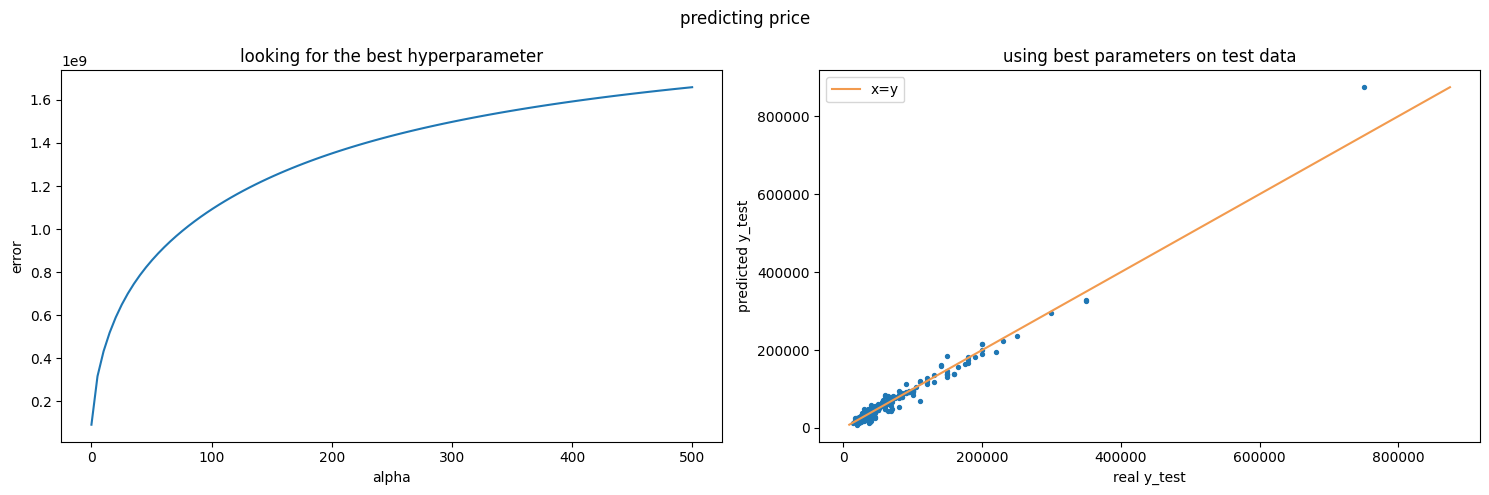

In [234]:
warnings.filterwarnings("ignore", category=LinAlgWarning)

from sklearn.linear_model import Ridge, RidgeClassifier
alphas = np.linspace(0.01, 500., 100) 
model_with_one_hyperparameter(
    lambda p: Ridge(alpha=p), lambda model: model.alpha, alphas, 'alpha', 'predicting price',
    x_train_price, x_valid_price, x_test_price, y_train_price, y_valid_price, y_test_price,
    is_classification=False)

best model
  alpha: 1e-06
  valid error: 0.3384615384615385
  test error:  0.38461538461538464


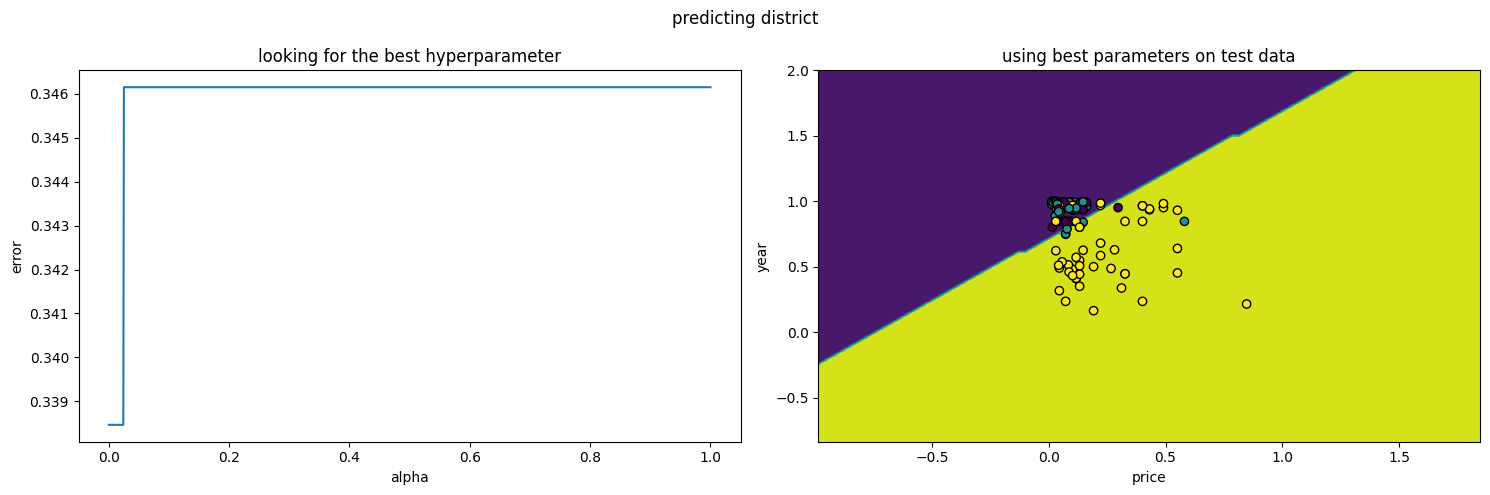

In [235]:
model_with_one_hyperparameter(
    lambda p: RidgeClassifier(alpha=p), lambda model: model.alpha,
    np.linspace(0.000001, 1.0, 1000), 'alpha', 'predicting district',
    x_train_ds, x_valid_ds, x_test_ds, y_train_ds, y_valid_ds, y_test_ds)

#### байесовская модель

best model
  : no hyperparameters
  valid error: 0.32307692307692304
  test error:  0.5384615384615384


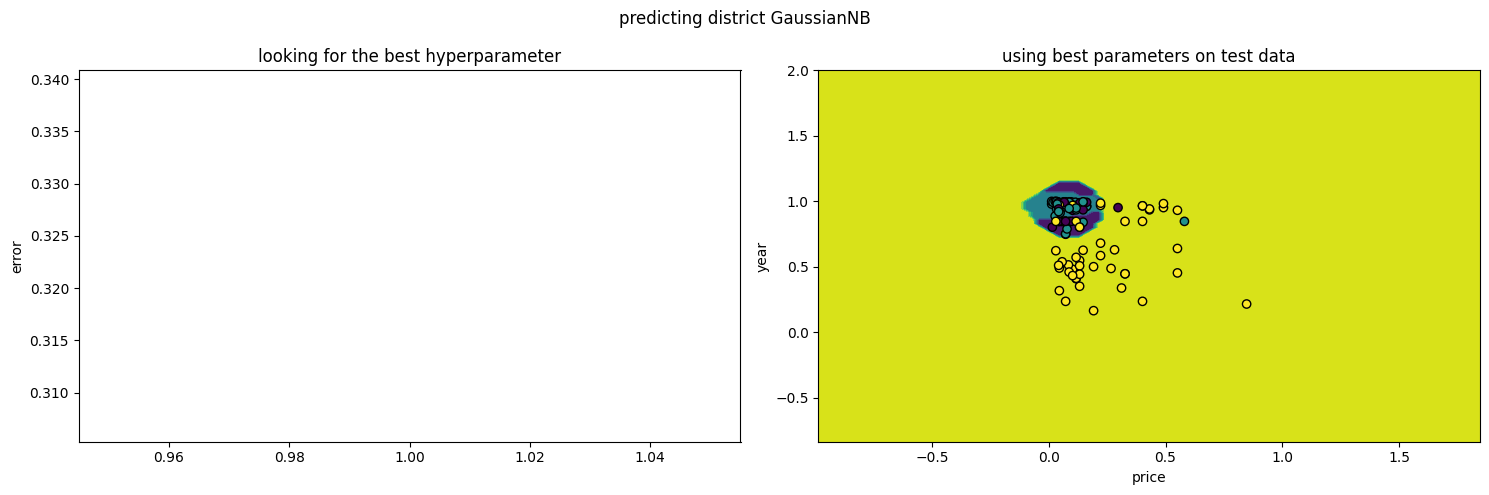

best model
  alpha: 1e-08
  valid error: 0.39230769230769236
  test error:  0.4461538461538462


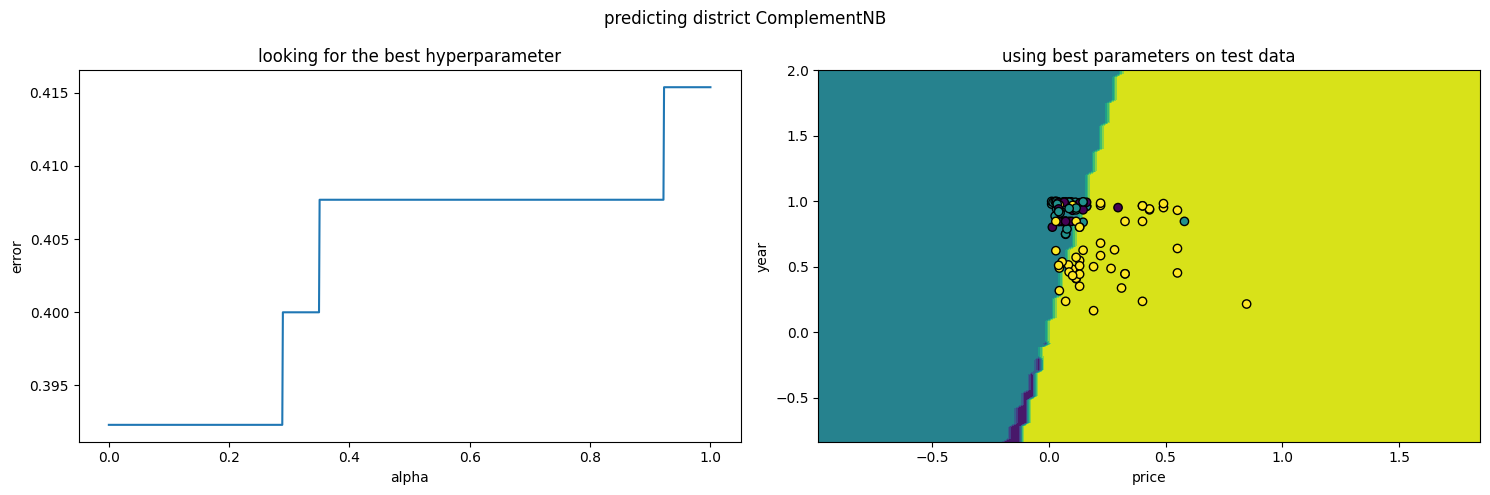

In [236]:
from sklearn.naive_bayes import GaussianNB, ComplementNB
model_with_one_hyperparameter(
    lambda p: GaussianNB(), lambda model: 'no hyperparameters',
    [1] , '', 'predicting district GaussianNB',
    x_train_ds, x_valid_ds, x_test_ds, y_train_ds, y_valid_ds, y_test_ds)
model_with_one_hyperparameter(
    lambda p: ComplementNB(alpha=p), lambda model: model.alpha,
    np.linspace(0.00000001, 1.0, 1000) , 'alpha', 'predicting district ComplementNB',
    x_train_ds, x_valid_ds, x_test_ds, y_train_ds, y_valid_ds, y_test_ds)

#### деревья принятия решений

best model
  max depth: 7
  valid error: 0.24615384615384617
  test error:  0.5461538461538461


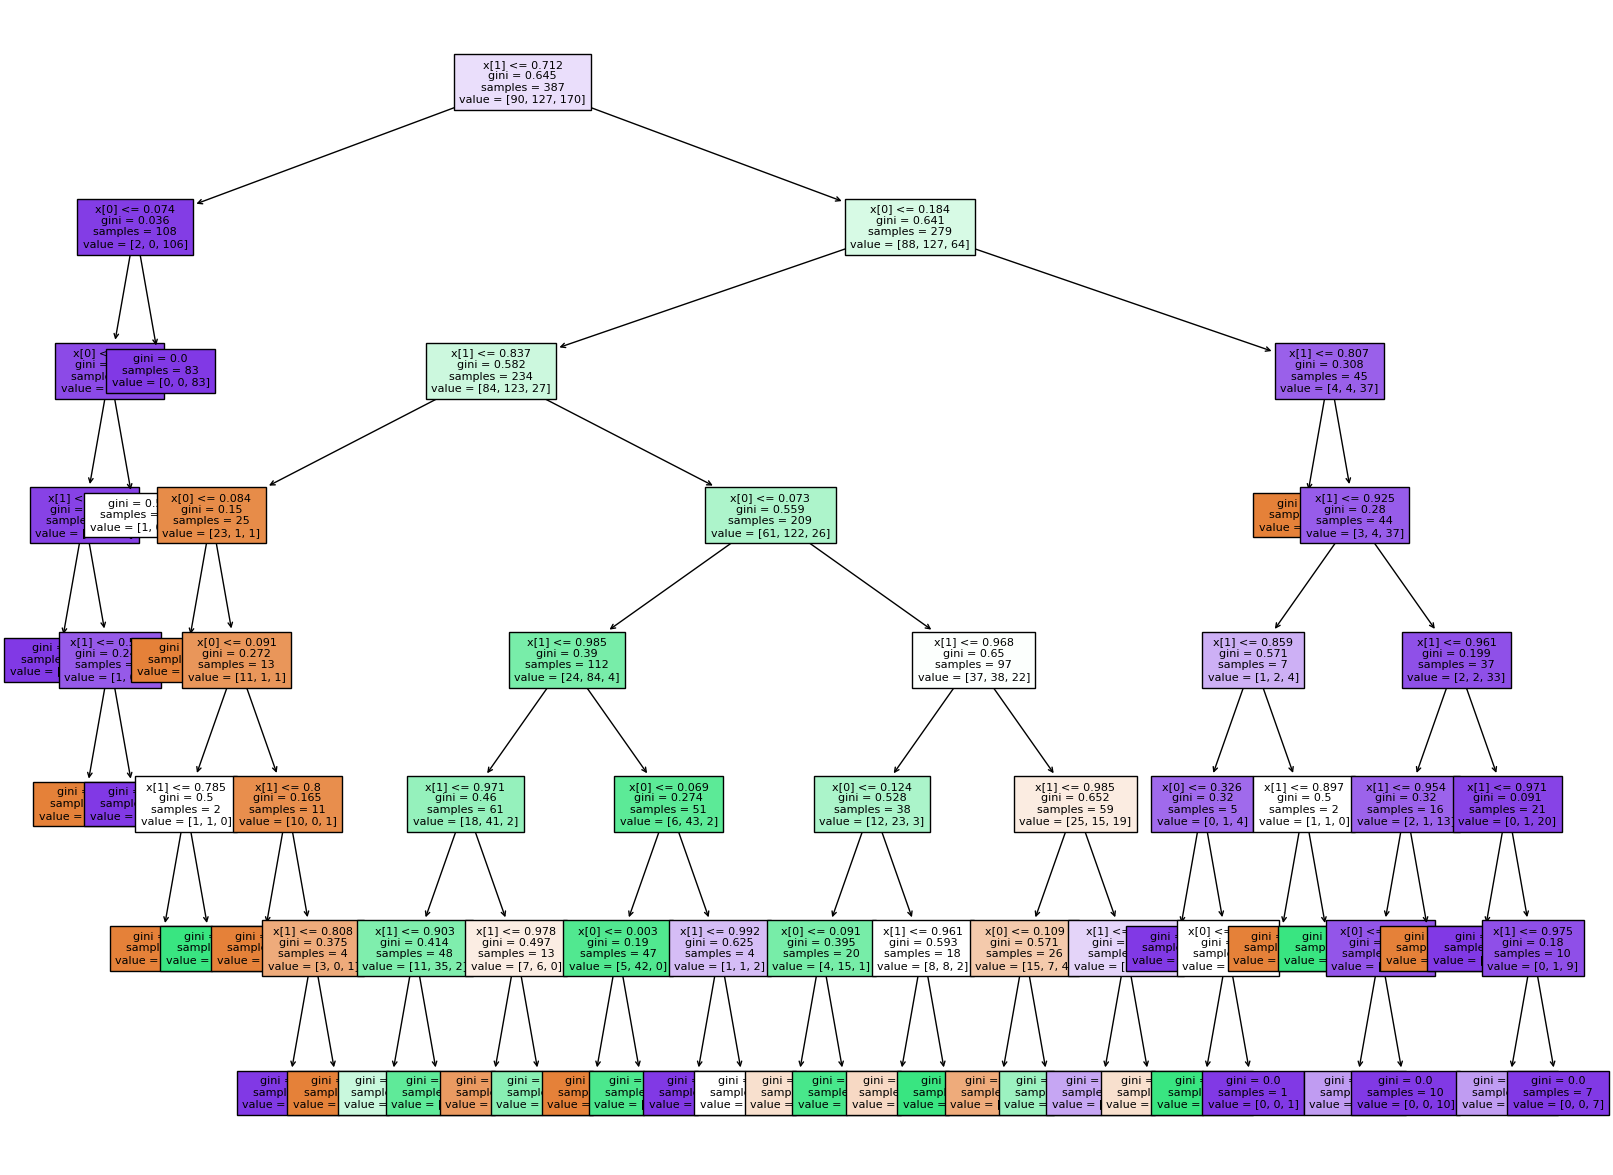

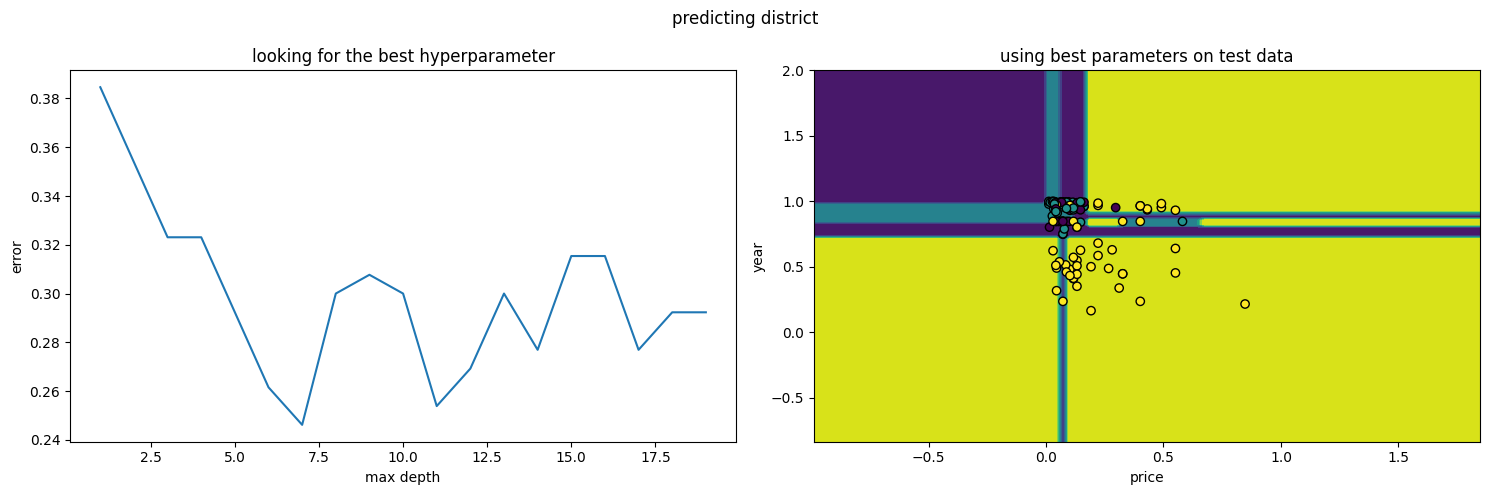

In [237]:
from sklearn.tree import DecisionTreeClassifier

model_with_one_hyperparameter(
    lambda p: DecisionTreeClassifier(max_depth=p), lambda model: model.max_depth,
    range(1, 20) , 'max depth', 'predicting district',
    x_train_ds, x_valid_ds, x_test_ds, y_train_ds, y_valid_ds, y_test_ds,
    draw_tree=True)

#### ансамбль

best model
  max depth: 10
  valid error: 0.24615384615384617
  test error:  0.43846153846153846


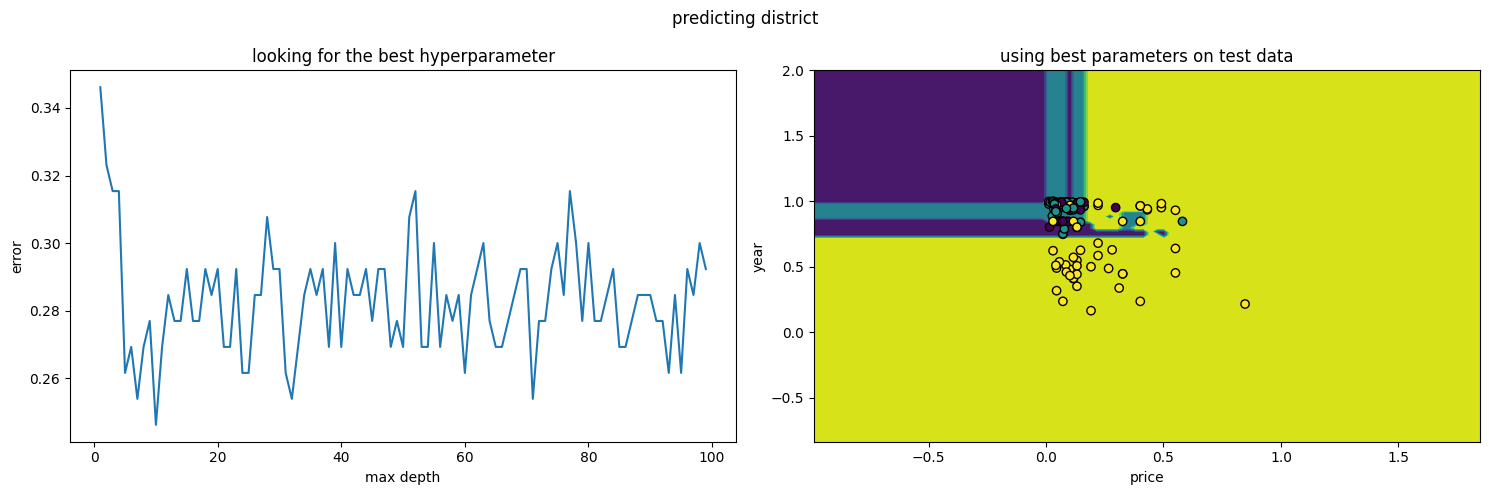

In [238]:
from sklearn.ensemble import RandomForestClassifier

model_with_one_hyperparameter(
    lambda p: RandomForestClassifier(max_depth=p), lambda model: model.max_depth,
    range(1, 100) , 'max depth', 'predicting district',
    x_train_ds, x_valid_ds, x_test_ds, y_train_ds, y_valid_ds, y_test_ds)